## Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from math import pi
from skimage import morphology
from skimage.morphology import opening
from skimage import transform
from skimage import filters

## Paths

In [2]:
IMG_PATH = '../data/example_image/'
SUPER_IMG_PATH = '../data/example_image/'
SEG_PATH = '../data/example_segmentation/'

TRUTH = '../data/example_ground_truth.csv'
FEATURES = '../features/features.csv'

## Functions

In [3]:
def rgb2gray(circle_reference):

    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b

    return gray


def mask(image, sens):
    '''takes path to .jpg and returns a masked image'''
    img =  image
    #also want to be able to crop the image automaticallty here
    gray = rgb2gray(img) #create grayscale thingy
    img2 = gray < sens # **This level needs manually adjusting, also need to be able to automate**
    
    return img2

def dimensions(mask1):
    '''calculates height(max) and width(90 deg to height)
        returns height, width, rotated mask image, degree of rotation'''
    pixels_in_col = np.max(np.sum(mask1, axis=0))

    rot = 0
    max_col = 0
    rot_max = 0
    for _ in range(18):
        rot_im = transform.rotate(mask1,rot)
        pixels_in_col = np.max(np.sum(rot_im, axis=0))
        if pixels_in_col > max_col:
            max_col = pixels_in_col
            rot_max = rot
        rot += 10

    pixels_in_row = np.max(np.sum(mask1, axis=1))    
    return max_col, pixels_in_row, rot_max

def perimeter(mask1):
    '''calcs mask perimeter, returns outline image and length of perimeter'''
    struct_el = morphology.disk(5)
    mask_eroded = morphology.binary_erosion(mask1, struct_el)
    image_perimeter = mask1 - mask_eroded

    return image_perimeter, np.sum(image_perimeter)

## Import single image and create mask

(2830, 3145, 3)
(2830, 3145)


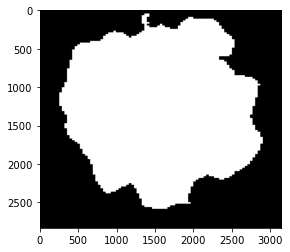

In [4]:
IMG = 'ISIC_0013518'
image = plt.imread(IMG_PATH+IMG+'.jpg')
mask1 = plt.imread(SEG_PATH+IMG+'_segmentation.png')

plt.imshow(mask1, cmap='gray');

mask = np.where(mask1 == 1)

x_min = min(mask[0])
if x_min > 250:
    x_min -= 250
else:
    x_min = 0
y_min = min(mask[1])
if y_min > 250:
    y_min -= 250
else:
    y_min = 0
    
x_max = max(mask[0])+250
y_max = max(mask[1])+250




image = image[x_min:x_max,y_min:y_max]
mask1 = mask1[x_min:x_max,y_min:y_max]


print(image.shape)
print(mask1.shape)

plt.imshow(mask1, cmap='gray');

8900350 4680699.0
52.59005544725769


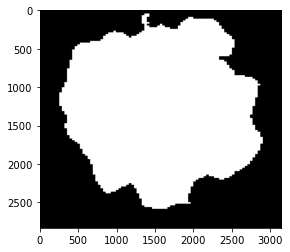

In [5]:
#Total size of the image
total = mask1.shape[0] * mask1.shape[1] 

#Size of mask only
area = np.sum(mask1)
print(total, area)
#As percentage
print(area/total*100)

plt.imshow(mask1, cmap='gray');

Height: 2736.81, 
Width: 2579.00


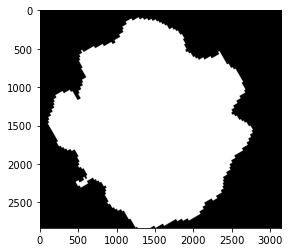

In [6]:
height, width, rot_max = dimensions(mask1)
rot_img = transform.rotate(mask1,rot_max)
print(f'Height: {height:.2f}, \nWidth: {width:.2f}')
plt.imshow(rot_img, cmap='gray');

Length: 52778.01


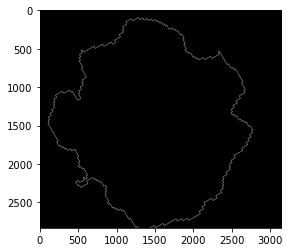

In [7]:
image_perimeter, peri = perimeter(rot_img)
print(f'Length: {peri:.2f}')
plt.imshow(image_perimeter, cmap='gray');

In [8]:
est_rad = height/2 #would be the circle that encloses the largest dimension

print(est_rad)

est_circ = 2*pi*est_rad
est_area = pi*(est_rad*est_rad)

print(f'Difference in circumference: {abs(peri-est_circ):.2f} \nDifference in area: {abs(area-est_area):.2f}')

1368.4056396484375
Difference in circumference: 44180.07 
Difference in area: 1202040.04


In [9]:
def features(image, bi_image):
    mask = np.where(bi_image == 1)
    x_min = min(mask[0])
    if x_min > 250:
        x_min -= 250
    else:
        x_min = 0
    y_min = min(mask[1])
    if y_min > 250:
        y_min -= 250
    else:
        y_min = 0

    x_max = max(mask[0])+250
    y_max = max(mask[1])+250

    image = image[x_min:x_max,y_min:y_max]
    bi_image = bi_image[x_min:x_max,y_min:y_max]
    
    height, width, rot_deg = dimensions(bi_image)
    area = np.sum(bi_image)
    
    est_rad = height/2
    est_circ = 2*pi*est_rad
    est_area = pi*(est_rad*est_rad)
    
    area_dif = abs(area-est_area)
    circ_dif = abs(peri-est_circ)
    
    return area_dif, circ_dif
    

In [10]:
area, circ = features(image, mask1)
print(area, circ)

1202040.0411005225 44180.065509449254


## Load dataframes

In [11]:
truth = pd.read_csv(TRUTH)
truth.head()

IMG[5:]

'0013518'

In [12]:
cancer = truth[truth['melanoma'] == 1]
cancer.shape

(30, 3)

In [13]:
#This takes around 20mins to run, so it's been exported as a csv 'features_v1.csv' for now

#features_df = pd.DataFrame(columns = ['id', 'area', 'circ','melanoma'])
#c=0
#for name in truth['image_id']:
#    image = plt.imread(IMG_PATH+name+'.jpg')
#    mask1 = plt.imread(SEG_PATH+name+'_segmentation.png')
#    area, circ = features(image, mask1)
#    features_df.loc[c] = [name[5:], area, circ,truth[truth['image_id'] == name].iloc[0]['melanoma']]
#    
#    c += 1

In [24]:
features_df.shape

(150, 4)

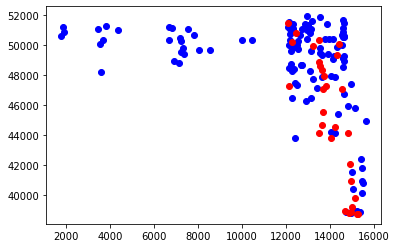

In [15]:
features_df['id'] = features_df['id'].astype(int)

mel = features_df[features_df['melanoma']==1.0]
clear = features_df[features_df['melanoma']==0.0]
plt.scatter(clear['id'], clear['circ'], c='blue');
plt.scatter(mel['id'], mel['circ'], c='red');

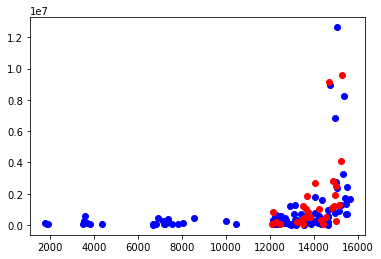

In [16]:
plt.scatter(clear['id'], clear['area'], c='blue');
plt.scatter(mel['id'], mel['area'], c='red');

In [25]:
features_df.to_csv(r'../features_v1.csv', header=True, index= False)